In [22]:
train_dir = '/kaggle/input/covidnew/ALL/Train' 
val_dir = '/kaggle/input/covidnew/ALL/Train' 
test_dir = '/kaggle/input/covidnew/ALL/Test'

In [23]:
#ELEGIMOS LOS PARAMETROS
from keras.preprocessing.image import ImageDataGenerator
ih, iw = 256,256 #tamano de la imagen
input_shape = (ih, iw, 3) #forma de la imagen: alto ancho y numero de canales

num_class = 2 #cuantas clases 
#epochs = 15 #cuantas veces entrenar. En cada epoch hace una mejora en los parametros

batch_size = 32 #batch para hacer cada entrenamiento. Lee 50 'batch_size' imagenes antes de actualizar los parametros. Las carga a memoria
num_train = 21715 #numero de imagenes en train
num_test = 6788 #numero de imagenes en test
num_val=5417

epoch_steps = num_train // batch_size 
test_steps = num_test // batch_size
 

In [24]:
#LEEMOS LAS IMÁGENES 
from keras.applications.imagenet_utils import preprocess_input
img_height, img_width=ih, iw

train_datagen = ImageDataGenerator(rescale=1./255,
                                    #preprocessing_function=preprocess_input,
                                      validation_split=0.3)
val_datagen=ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    subset='training',
    batch_size=batch_size,
    class_mode='categorical') # set as training data

validation_generator = train_datagen.flow_from_directory(
    val_dir, # same directory as training data
    target_size=(img_height, img_width),
    subset='validation',
    batch_size=batch_size,
    class_mode='categorical') # set as validation data

test_generator = val_datagen.flow_from_directory(
    test_dir, # same directory as training data
    target_size=(img_height, img_width),

    batch_size=batch_size,
    class_mode='categorical') # set as validation data

Found 14461 images belonging to 2 classes.
Found 6196 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [25]:
train=train_generator
val=validation_generator
test=test_generator

In [26]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2

InceptionV3_model = Xception(include_top=False, weights='imagenet',  
                                     input_shape=input_shape) 

InceptionV3_model.trainable=False

83697664/83683744 [==============================] - 0s 0us/step


In [27]:
import pandas as pd 
pd.set_option('max_colwidth', -1)

layers = [(layer, layer.name, layer.trainable) for layer in InceptionV3_model.layers] 
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7fa6d0c82fd0>,input_2,False
1,<keras.layers.convolutional.Conv2D object at 0x7fa764f4ef90>,block1_conv1,False
2,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fa764b39c90>,block1_conv1_bn,False
3,<keras.layers.core.Activation object at 0x7fa6d0cd1c10>,block1_conv1_act,False
4,<keras.layers.convolutional.Conv2D object at 0x7fa7640f98d0>,block1_conv2,False
...,...,...,...
127,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fa6d08cb390>,block14_sepconv1_bn,False
128,<keras.layers.core.Activation object at 0x7fa6d085f910>,block14_sepconv1_act,False
129,<keras.layers.convolutional.SeparableConv2D object at 0x7fa6d04ee150>,block14_sepconv2,False
130,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fa6d0527dd0>,block14_sepconv2_bn,False


In [28]:
InceptionV3_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [29]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [30]:
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import to_categorical 
from keras import optimizers 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, BatchNormalization
# build model architecture 
model = Sequential()
model.add(InceptionV3_model)
model.add(Flatten())
#model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(num_class, activation='softmax'))
#compile model
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.001, momentum=0.9), 
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True), 
      metrics=['accuracy',f1_m,precision_m, recall_m])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 262146    
Total params: 21,123,626
Trainable params: 262,146
Non-trainable params: 20,861,480
_________________________________________________________________
None


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [31]:
import time
inicio=time.time()
history = model.fit_generator(train, 
                              epochs=10,  
                              validation_data=val,
                              verbose=1)
fin=time.time()
print(inicio-fin)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4847: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


452/452 [==============================] - 76s 162ms/step - loss: 0.5376 - accuracy: 0.8584 - f1_m: 0.8585 - precision_m: 0.8585 - recall_m: 0.8585 - val_loss: 0.2506 - val_accuracy: 0.9280 - val_f1_m: 0.9281 - val_precision_m: 0.9281 - val_recall_m: 0.9281
Epoch 2/10
452/452 [==============================] - 74s 163ms/step - loss: 0.3062 - accuracy: 0.9152 - f1_m: 0.9152 - precision_m: 0.9152 - recall_m: 0.9152 - val_loss: 0.2606 - val_accuracy: 0.9311 - val_f1_m: 0.9310 - val_precision_m: 0.9310 - val_recall_m: 0.9310
Epoch 3/10
452/452 [==============================] - 70s 155ms/step - loss: 0.2313 - accuracy: 0.9352 - f1_m: 0.9352 - precision_m: 0.9352 - recall_m: 0.9352 - val_loss: 0.2009 - val_accuracy: 0.9398 - val_f1_m: 0.9396 - val_precision_m: 0.9396 - val_recall_m: 0.9396
Epoch 4/10
452/452 [==============================] - 70s 154ms/step - loss: 0.1534 - accuracy: 0.9485 - f1_m: 0.9485 - precision_m: 0.9485 - recall_m: 0.9485 - val_loss: 0.5047 - val_accuracy: 0.8765 - v

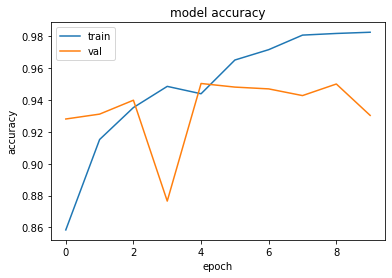

-0.19365310668945312


In [32]:
# summarize history for accuracy
import time
inicio=time.time()
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
fin=time.time()
print(inicio-fin)

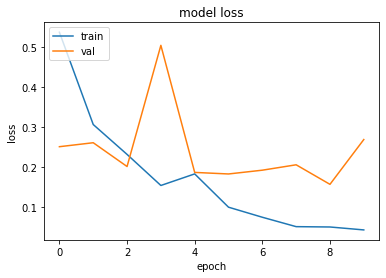

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

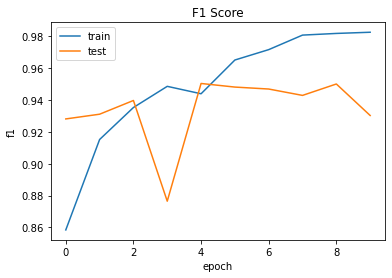

In [34]:
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('F1 Score')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

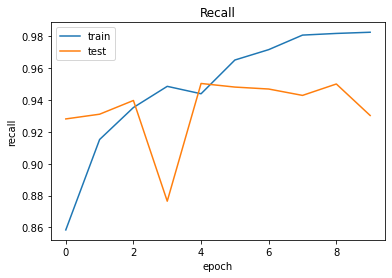

In [35]:
plt.plot(history.history['recall_m'])
plt.plot(history.history['val_recall_m'])
plt.title('Recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

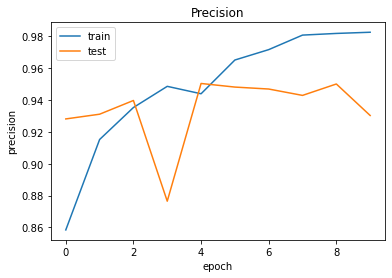

In [36]:
plt.plot(history.history['precision_m'])
plt.plot(history.history['val_precision_m'])
plt.title('Precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [37]:
test_eval = model.evaluate(test, verbose=1)
print('El modelo predice el ', test_eval[1]*100,'% de los datos')

63/63 [==============================] - 8s 132ms/step - loss: 0.2577 - accuracy: 0.9250 - f1_m: 0.9246 - precision_m: 0.9246 - recall_m: 0.9246
El modelo predice el  92.5000011920929 % de los datos


In [38]:
print('Utilizando el conjunto de datos de test para evaluar el modelo')
print('Loss: ',test_eval[0])
print('Accuracy: ',test_eval[1])
print('F1 Score: ',test_eval[2])
print('Precision: ',test_eval[3])
print('Recall: ',test_eval[4])

Utilizando el conjunto de datos de test para evaluar el modelo
Loss:  0.25774085521698
Accuracy:  0.925000011920929
F1 Score:  0.9246031641960144
Precision:  0.9246031641960144
Recall:  0.9246031641960144
